In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random

In [2]:
##------------------------------Pegando os Dados-----------------------------------

#url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-12-21/2019-03-21/A307"
url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-01-01/2019-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    df.dropna(inplace=True)
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    #df_umid["id"] = df.index + 1

<ipython-input-2-4c0a7404db43>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1


In [3]:

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalTemp = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit['TEMP_MAX'])
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalUmid = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit['UMID_MED'])
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def extrairErro(dataframe):
    #train_size = int(dataframe.shape[0] * 1)
    #train = dataframe[1:train_size]
    #train_X, train_y = train.to_numpy()[:,0], train.to_numpy()[:,1]
    #train_pred = [x for x in train_X]
    #train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
    desvioErro = np.std(dataframe)
    return desvioErro

def TransformarEmEstacionaria(df_training_temp):
    df_training_temp["TEMP_MAX"] = df_training_temp["TEMP_MAX"].astype(float)
    df_training_temp["UMID_MED"] = df_training_temp["UMID_MED"].astype(float)
        
    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

In [116]:
#------------------------------Tratando os Dados-----------------------------------

def dataTraining(percentOutliers, dbscan):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    if dbscan:
        qtd_training_temp = qtdRowsTemp()
    
    df_training_temp = df_temp.sample(qtd_training_temp)

    df_training_temp = TransformarEmEstacionaria(df_training_temp)
    
    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)
    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)

    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].astype(float)

    equacaoExpo = equacaoExponencial()
    
    temperaturas = autoReg(df_training_temp_anomalie_edit['TEMP_MAX'])
    umidades = autoReg(df_training_temp_anomalie_edit['UMID_MED'])
    
    df_ids = np.array(df_training_temp_anomalie_edit['id'])
    df_training_temp_anomalie_edit = pd.DataFrame()
    df_training_temp_anomalie_edit['TEMP_MAX']= temperaturas.tolist()
    df_training_temp_anomalie_edit['UMID_MED']= umidades.tolist()
    df_training_temp_anomalie_edit['id']= df_ids.tolist()
    
    valorFinalTemp = valorFinalTemperatura(df_training_temp_anomalie_edit, True, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_training_temp_anomalie_edit, True, equacaoExpo)

    #df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    #df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)
    
    dfAnomalias = pd.DataFrame()
    col = ['TEMP_MAX','UMID_MED', 'id']

    dfAnomalias = pd.DataFrame(columns=col)
    
    for index, row in df_training_temp_anomalie_edit.iterrows():
        valor = None
        row['TEMP_MAX'] += np.sign(row['TEMP_MAX']) * valorFinalTemp
        row['UMID_MED'] += np.sign(row['UMID_MED']) * valorFinalTemp

        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])
        
        df1.set_index('id',inplace=True)
        
        df_training_temp = pd.concat([df1, df_training_temp])
        dfAnomalias = pd.concat([df1, dfAnomalias])
    
    dfAnomalias = dfAnomalias.drop(columns='id')
    
    print ('Qtd Anomalias: ' + str(dfAnomalias.shape[0]))
    print (dfAnomalias)
    
    for index, row in df_training_temp.iterrows():
        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])
        
        df1.set_index('id',inplace=True)
        
        dfAnomalias = pd.concat([df1, dfAnomalias])

    dfAnomalias.sort_index(inplace=True)    
    df_training_temp = dfAnomalias
        
    #df_training_temp_anomalie_edit.sort_index(inplace=True)   
    #df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)

    #df_training_temp = pd.concat([dfAnomalias, df_training_temp])
    df_training_temp.dropna(inplace=True)

    #Treino
    df_training_temp["TEMP_MAX"] = df_training_temp["TEMP_MAX"].astype(float)
    df_training_temp["UMID_MED"] = df_training_temp["UMID_MED"].astype(float)
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)
    #df_training_temp = df_training_temp.drop(columns='id')
        
    #Teste
    count_test_temp = int((df_test_temp.shape[0] * percentOutliers) / 100)
    df_test_temp_anomalie_edit = df_test_temp.sample(n=count_test_temp, random_state=1)
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_test_temp_anomalie_edit.dropna(inplace=True)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].astype(float)
    
    valorFinalTemp = valorFinalTemperatura(df_test_temp_anomalie_edit, False, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_test_temp_anomalie_edit, False, equacaoExpo)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit])
    
    df_test_temp["TEMP_MAX"] = df_test_temp["TEMP_MAX"].astype(float)
    df_test_temp["UMID_MED"] = df_test_temp["UMID_MED"].astype(float)
    df_test_temp.sort_index(inplace=True)

    df_test_temp.dropna(inplace=True)
    df_test_temp = df_test_temp.drop(columns='id')
    desvioPadrao = (desvioPadraoTempTraining + desvioPadraoUmidTraining) / 2
    return df_training_temp, df_test_temp

In [112]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

def autoReg(dataframe_anomalies_edit):
    ar_model = AutoReg(np.array(dataframe_anomalies_edit), trend='n', lags=1).fit()
    pred = ar_model.predict(start=0,end= dataframe_anomalies_edit.shape[0], dynamic=False)
    #print (pred)
    return pred

In [119]:
#import random

taxaContaminacao = 5
dfs = dataTraining(taxaContaminacao, True)
df_training_temp = dfs[0]
df_test_temp = dfs[1]

print (df_training_temp.head(n=50).to_string(index=True))

#idx = df_test_temp.index[df_test_temp['TEMP_MAX']]
#print (teste)

/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Qtd Anomalias: 30
        TEMP_MAX   UMID_MED
485.0 -13.258789  16.330903
529.0  13.416793 -18.796294
665.0 -12.957146  13.077604
679.0 -13.230061  17.474641
545.0  13.373701 -15.847992
693.0 -13.488613  14.678837
719.0 -13.445521  14.856752
236.0  13.072058  16.152988
463.0  13.115150 -18.262549
371.0 -12.971510  14.983834
614.0  12.942782  15.949657
346.0  12.985874 -14.907585
351.0  13.186969 -15.492162
398.0 -13.086422  14.119677
624.0  12.985874  16.025906
299.0 -13.215697  13.280936
243.0  13.388065  14.399257
512.0 -13.273153  13.535100
549.0  13.086422 -15.720910
423.0 -12.942782 -13.585932
275.0  13.186969  14.068844
60.0   13.201333 -15.466746
450.0  13.258789 -18.160884
285.0  13.115150  15.212582
697.0  13.043330 -13.992595
258.0  13.373701 -15.060083
241.0  13.330609 -15.085500
280.0 -13.330609  15.797159
332.0 -13.014602 -13.560516
356.0 -13.028966  13.357185
      TEMP_MAX  UMID_MED
1.0       11.2     -23.7
2.0        2.4      -9.1
3.0        5.7      -8.6
4.0       -2.3

611

Outliers encontrados: 
(28, 2)
        TEMP_MAX   UMID_MED
1.0    11.200000 -23.700000
22.0    4.900000 -37.800000
38.0   -8.400000  31.800000
184.0  -3.900000 -13.000000
223.0   7.700000 -26.500000
236.0  13.072058  16.152988
243.0  13.388065  14.399257
248.0   6.300000 -40.700000
275.0  13.186969  14.068844
282.0   2.600000 -29.500000
285.0  13.115150  15.212582
300.0   9.000000 -18.200000
332.0 -13.014602 -13.560516
337.0  -2.900000  34.000000
350.0   1.400000 -27.100000
412.0  -5.400000  36.800000
423.0 -12.942782 -13.585932
460.0   1.200000  18.300000
484.0   7.500000  -9.100000
526.0  -7.000000  31.300000
556.0  -8.100000   2.600000
585.0  -7.500000  24.900000
614.0  12.942782  15.949657
624.0  12.985874  16.025906
635.0   6.200000 -31.800000
651.0   1.700000 -29.500000
706.0   7.200000 -34.000000
713.0   6.700000 -36.000000


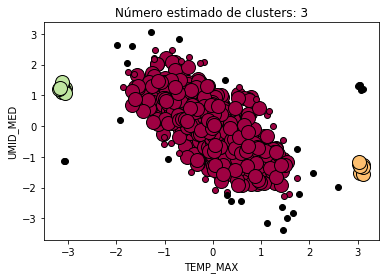

In [126]:
#------------------------------Implementando o DBSCAN-----------------------------------
def dbscan_part1(df_used, eps, min_samples):
    #X = np.array([ [1, 2], [2, 2], [7, 6], [28, 7], [2, 3], [25, 8], [3, 2],[1, 3],[1.1, 2],[1.2, 2],[1.3, 2],[1.4, 2]])
    X = np.array(df_used)
    X = StandardScaler().fit_transform(df_used)
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='brute').fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    outliers = df_used[db.labels_ == -1]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Preto usado para ruído
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    print ()
    outliers = outliers[outliers.index.notnull()]
    
    print('Outliers encontrados: ')
    print (outliers.shape)
    print (outliers.head(n=150).to_string(index=True))

    plt.title('Número estimado de clusters: %d' % n_clusters_)
    plt.xlabel("TEMP_MAX")
    plt.ylabel("UMID_MED")
    plt.show()

eps = 0.4
min_samples = 8
#x = np.array([[10, 50], [12, 50], [48, 70]], np.float)
df_training_temp = df_training_temp[df_training_temp.index.notnull()]
#print(df_training_temp.head(n=700).to_string(index=True))
print (df_training_temp.shape[0])
dbscan_part1(df_training_temp, eps, min_samples)


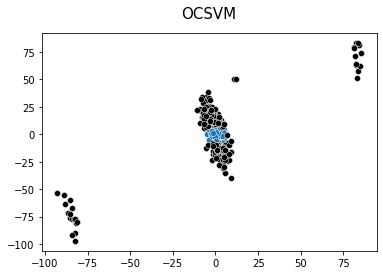

In [22]:
from sklearn.svm import OneClassSVM
import seaborn as sns

#x = np.array([[10, 50], [12, 50]], np.float)
#df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
#df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)


X = np.array(df_training_temp)
X, _ = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.5, coef0=0.0,tol=0.001,
                    shrinking=True,cache_size=10,
                    verbose=False,max_iter=-1).fit(X)
pred = ocsvm.predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sns.scatterplot(x=X[:,0], y=X[:,1])
sns.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='black')
plt.title("OCSVM", fontsize=15, pad=15)
plt.savefig("One-Class SVM Detection.png", dpi=80)

Text(0, 0.5, 'UMID_MED')

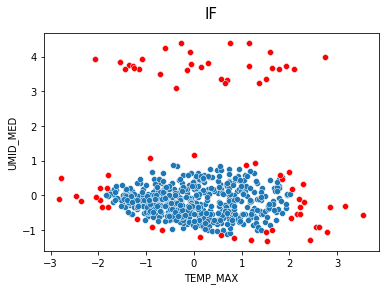

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns

x = np.array([[10, 50], [12, 50]], np.float)
df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)

X = np.array(df_training_temp)

iforest = IsolationForest(n_estimators=300, max_samples=df_training_temp.shape[0], 
                          warm_start=False,
                          contamination='auto', max_features=1.0, 
                          bootstrap=False, n_jobs=None, random_state=None)

pred = iforest.fit_predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sc=StandardScaler()
X_scaled = sc.fit_transform(X)
outlier_values_scaled = sc.transform(outlier_values)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
outlier_values_pca = pca.transform(outlier_values_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
sns.scatterplot(x=outlier_values_pca[:,0], 
                y=outlier_values_pca[:,1], color='r')
plt.title("IF", fontsize=15, pad=15)
plt.xlabel("TEMP_MAX")
plt.ylabel("UMID_MED")

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

X_test = np.array(df_test_temp)
X_train = np.array(df_training_temp)

# fit the model
clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma='scale').fit(X_train)
y_pred_train = clf.predict(X_train)
print (y_pred_train)
print ()
y_pred_test = clf.predict(X_test)
print (y_pred_test)

'''
outlier_index = np.where(y_pred_train==-1)
outlier_values = X_train[outlier_index]
print (outlier_values)
'''


[ 1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1
 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1
 -1  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1
 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1 -1  1 -1
  1 -1  1  1  1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1  1
 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1
  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1
  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1
 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1
 -1  1  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1 -1  1
  1 -1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1

'\noutlier_index = np.where(y_pred_train==-1)\noutlier_values = X_train[outlier_index]\nprint (outlier_values)\n'